In [ ]:
import os
import sys
import math
import json
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision. datasets as datasets
import torchvision.transforms as transforms
from pgd_utils import pgd
from expl_utils import *
from bbmp import bbmp
import matplotlib.pyplot as plt
from skimage import feature, transform

In [172]:
def parse_args():
    parser = argparse.ArgumentParser(description='Example Usage on MNIST')
    parser.add_argument('--gpu', type=int, default=0)
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--norm', type=int, default=2)
    parser.add_argument('--pgd-eps-start', type=float, default=10.)     
    parser.add_argument('--pgd-niter', type=int, default=100)
    parser.add_argument('--pgd-step-size', type=float, default=1.)
    args, _ = parser.parse_known_args()
    return args

# setting up config
args = parse_args()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(args.gpu)

In [173]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class UnnormInputModel(nn.Module):
    def __init__(self, model, mean, std):
        super(UnnormInputModel, self).__init__()
        self.model = model
        self.mean = mean
        self.std = std
    
    def forward(self, x):
        x_normed = (x - self.mean) / self.std
        return self.model(x_normed)
    

# prepare model
model = Net()
model.load_state_dict(torch.load('mnist_cnn.pt')) # load pretrained model
model = UnnormInputModel(model, mean=0.1307, std=0.3081)  # wrap the model with a normalization layer
model = model.to(device)
model.eval()

# model sanity check
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=False, transform=transforms.ToTensor(), download=True),
    batch_size=512, shuffle=True)

correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

print('\nTest Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test Accuracy: 9895/10000 (99%)



Predicted Class: 4


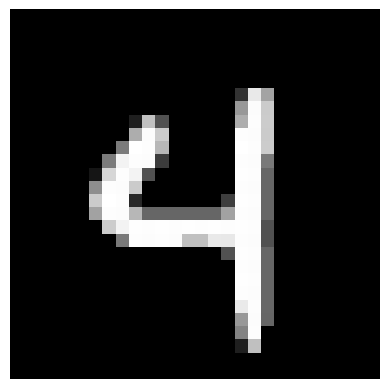

In [175]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

Xs, ys = next(iter(test_loader))
Xs_np = Xs.numpy()
plt.imshow(Xs_np.reshape(28, 28), cmap='gray')
plt.axis('off')

Xs = Xs.to(device)
ys = ys.to(device).long()
assert Xs.shape == (1, 1, 28, 28)
assert ys.shape == (1,)

ys_pred = model(Xs).argmax()
print('Predicted Class:', ys_pred.item())

In [176]:
# Grad
expl_grad = saliency_expl('Grad', Xs, ys, model)
# SHAP
expl_shap = saliency_expl('SHAP', Xs, ys, model)
# Greedy-AS
expl_greedy_as = greedy_as(Xs, ys, model, targeted=False, target=None, norm=args.norm,
                           eps_start=args.pgd_eps_start, step_size=args.pgd_step_size, niters=args.pgd_niter,
                           device=device, reverse_anchor=False)

Computing explanation by Grad...
Computing explanation by SHAP...
Computing explanation by Greedy-AS...
number of relevant features selected: 0.0
number of relevant features selected: 39.0
number of relevant features selected: 78.0
number of relevant features selected: 117.0
number of relevant features selected: 156.0
number of relevant features selected: 195.0
number of relevant features selected: 234.0
number of relevant features selected: 273.0
number of relevant features selected: 312.0
number of relevant features selected: 351.0
number of relevant features selected: 390.0


In [177]:
def visualize(Xs, expls, percentage=15, labels=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from skimage import transform, feature

    def select_top_k(expl):
        expl = np.copy(expl)
        expl += np.random.uniform(-1e-12, 1e-12, size=expl.shape)  # for ranking stability
        threshold = np.percentile(expl, 100 - percentage)
        top_k_expl = np.copy(expl)
        top_k_expl[expl <= threshold] = 0
        top_k_expl[expl > threshold] = 1
        return top_k_expl

    # Compute edge for overlay
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, Xs.shape[1], dx)
    yy = np.arange(0.0, Xs.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax    

    Xs = Xs.cpu().reshape(28, 28)

    xi = Xs
    alpha = 0.8
    dilation = 3.0
    cmap_xi = plt.get_cmap('Greys')  # Change to 'Greys' for black edges on white
    cmap_xi.set_bad(alpha=0)
    overlay = None

    # Compute edges (to overlay to heatmaps later)
    xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi.detach().cpu().numpy(), axis=-1)
    xi_greyscale = np.array(xi_greyscale)
    in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
    edges = feature.canny(in_image_upscaled).astype(float)
    edges[edges < 0.5] = np.nan
    edges[:5, :] = np.nan
    edges[-5:, :] = np.nan
    edges[:, :5] = np.nan
    edges[:, -5:] = np.nan
    overlay = edges

    # Visualize top-k relevant features
    top_k_expls = [select_top_k(expl).reshape(28, 28) for expl in expls]
        
    n_cols = len(expls) + 1
    n_rows = 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3 * n_cols, 3 * n_rows))

    # Add label for the original input
    axes[0].imshow(Xs, cmap='gray', interpolation='nearest')  # Original input in grayscale
    axes[0].set_title('Original Input', fontsize=10)
    axes[0].axis('off')

    for i, expl in enumerate(top_k_expls, 1):
        axes[i].imshow(expl, extent=extent, cmap='binary', vmin=0, vmax=1)  # Highlights in black on white
        axes[i].imshow(overlay, extent=extent, cmap=cmap_xi, alpha=alpha)  # Edge overlay in black
        if labels and i <= len(labels):
            axes[i].set_title(labels[i - 1], fontsize=10)  # Use labels if provided
        else:
            axes[i].set_title(f'Explanation {i}', fontsize=10)  # Default label
        axes[i].axis('off')

    plt.show()


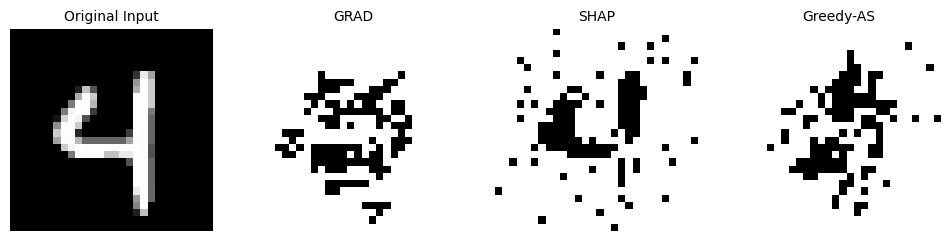

In [178]:
visualize(Xs, [expl_grad, expl_shap, expl_greedy_as],labels= ['GRAD', 'SHAP', 'Greedy-AS'])


In [179]:
def eval_curve_robust(Xs, ys, model, targeted, targets, norm, eps_start, step_size, niters, expl,
                      device, reverse_anchor):
    # set up logger
    logger = list()
    
    # for topk stability
    expl = np.copy(expl)
    expl += np.random.uniform(-1e-12, 1e-12, size=expl.shape)
    
    for i in range(0, 50, 5):
        threshold = np.percentile(expl, 100 - i)
        top_k_expl = np.copy(expl)
        top_k_expl[expl <= threshold] = 0
        top_k_expl[expl > threshold] = 1
        anchor_map = top_k_expl
        if reverse_anchor:
            anchor_map = np.logical_not(anchor_map)
        anchor_map = torch.BoolTensor(anchor_map).to(device)
        
        def binary_search_cond(Xs, ys, epsilons, anchor_map, targeted, targets):
            epsilons = torch.FloatTensor(epsilons).to(device)
            successes, Xs_pgd = pgd(Xs, ys, model, epsilons, norm, niters, step_size, anchor_map, targeted, targets=targets,
                                    box_min=0., box_max=1., verbose=False, multi_start=True, device=device)
            return successes, Xs_pgd
        
        robust_ub, Xs_pgd = binary_search(binary_search_cond, Xs, ys, np.full(len(Xs), eps_start), anchor_map, targeted, targets, tol=0.001, max_steps=25)
        robust_ub = robust_ub[0]
        logger.append(robust_ub)
        print('robustness:', robust_ub)

    return logger

In [186]:
eval_curve_grad = eval_curve_robust(Xs, ys, model, False, None, args.norm, args.pgd_eps_start,
                                    args.pgd_step_size, args.pgd_niter, expl_grad, device, True)
eval_curve_greedy_as = eval_curve_robust(Xs, ys, model, False, None, args.norm, args.pgd_eps_start,
                                        args.pgd_step_size, args.pgd_niter, expl_greedy_as, device, True)

robustness: inf
robustness: 2.65728759765625
robustness: 1.72125244140625
robustness: 1.507568359375
robustness: 1.45867919921875
robustness: 1.42132568359375
robustness: 1.393310546875
robustness: 1.3614501953125
robustness: 1.34716796875
robustness: 1.33343505859375
robustness: inf
robustness: 1.47900390625
robustness: 1.38287353515625
robustness: 1.380126953125
robustness: 1.36090087890625
robustness: 1.30816650390625
robustness: 1.30487060546875
robustness: 1.2955322265625
robustness: 1.30267333984375
robustness: 1.30047607421875


Text(0.5, 0, 'Percentage of Relevant Features (|$S_r$|/d)')

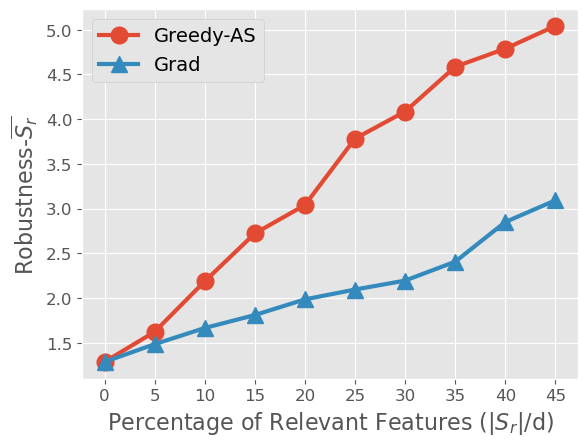

In [181]:
plt.style.use('ggplot')
markers = ['o', '^']
fig = plt.figure()
ax = plt.axes()

methods = ['Greedy-AS', 'Grad']
curves = [eval_curve_greedy_as, eval_curve_grad]

for i, (method, curve) in enumerate(zip(methods, curves)):
    steps = len(curve)
    ax.plot(np.arange(steps), curve, label=method, linewidth=3, marker=markers[i], markersize=12)


leg = plt.legend(framealpha = 1, loc = 2, fontsize=14)
for text in leg.get_texts():
    plt.setp(text, color='black')

plt.xticks(np.arange(10), np.arange(10)*5)
plt.tick_params(labelsize=12)
plt.ylabel(r'Robustness-$\overline{S_r}$', fontsize=16)
plt.xlabel(r'Percentage of Relevant Features (|$S_r$|/d)', fontsize=16)

In [187]:
eval_curve_shap = eval_curve_robust(Xs, ys, model, False, None, args.norm, args.pgd_eps_start,
                                    args.pgd_step_size, args.pgd_niter, expl_shap.reshape(1, 1, 28, 28), device, True)

robustness: inf
robustness: 2.65289306640625
robustness: 2.23486328125
robustness: 1.84539794921875
robustness: 1.806396484375
robustness: 1.81793212890625
robustness: 1.60589599609375
robustness: 1.55865478515625
robustness: 1.544921875
robustness: 1.49493408203125


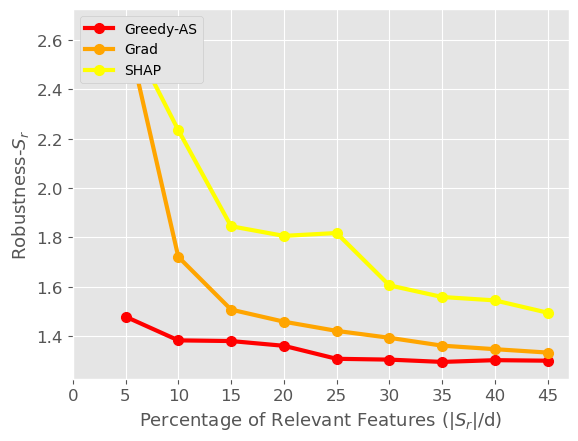

In [189]:
plt.style.use('ggplot')
markers = ['o', 'o', 'o']  # Markers for the methods
colors = ['red', 'orange', 'yellow']  # Line colors for each method
fig = plt.figure()
ax = plt.axes()

methods = ['Greedy-AS', 'Grad', 'SHAP']
curves = [eval_curve_greedy_as, eval_curve_grad, eval_curve_shap]

for i, (method, curve) in enumerate(zip(methods, curves)):
    steps = len(curve)
    ax.plot(
        np.arange(steps), 
        curve, 
        label=method, 
        linewidth=3, 
        marker=markers[i], 
        markersize=7, 
        color=colors[i]  # Set the color for each method
    )

# Add legend
leg = plt.legend(framealpha=1, loc=2, fontsize=10)
for text in leg.get_texts():
    plt.setp(text, color='black')

# Set axis labels and ticks
plt.xticks(np.arange(10), np.arange(10) * 5)
plt.tick_params(labelsize=12)
plt.ylabel(r'Robustness-${S_r}$', fontsize=13)
plt.xlabel(r'Percentage of Relevant Features (|$S_r$|/d)', fontsize=13)

# Show plot
plt.show()


In [ ]:
print(expl_shap.shape)

In [ ]:
print(expl_bbmp.shape)

In [ ]:
print(expl_grad.shape)

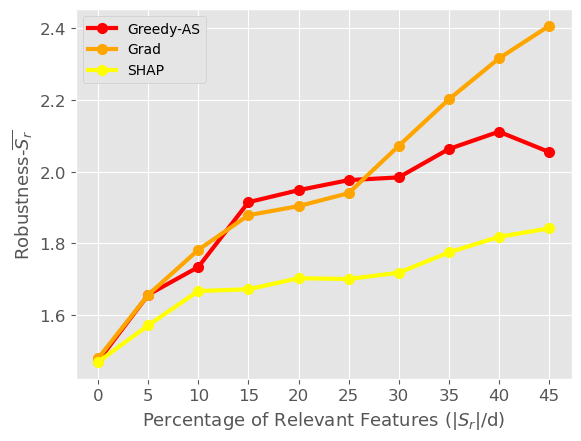

In [162]:
plt.style.use('ggplot')
markers = ['o', 'o', 'o']  # Markers for the methods
colors = ['red', 'orange', 'yellow']  # Line colors for each method
fig = plt.figure()
ax = plt.axes()

methods = ['Greedy-AS', 'Grad', 'SHAP']
curves = [eval_curve_greedy_as, eval_curve_grad, eval_curve_shap]

for i, (method, curve) in enumerate(zip(methods, curves)):
    steps = len(curve)
    ax.plot(
        np.arange(steps), 
        curve, 
        label=method, 
        linewidth=3, 
        marker=markers[i], 
        markersize=7, 
        color=colors[i]  # Set the color for each method
    )

# Add legend
leg = plt.legend(framealpha=1, loc=2, fontsize=10)
for text in leg.get_texts():
    plt.setp(text, color='black')

# Set axis labels and ticks
plt.xticks(np.arange(10), np.arange(10) * 5)
plt.tick_params(labelsize=12)
plt.ylabel(r'Robustness-$\overline{S_r}$', fontsize=13)
plt.xlabel(r'Percentage of Relevant Features (|$S_r$|/d)', fontsize=13)

# Show plot
plt.show()


In [ ]:
def shap(X, label, pdt, model, n_sample):
    X = X.cpu().numpy()
    Xs = np.repeat(X.reshape(1, -1), n_sample, axis=0)
    Xs_img = Xs.reshape(n_sample, 1, 28, 28)

    Zs = np.apply_along_axis(sample_shap_Z, 1, Xs)
    Zs_real = np.copy(Zs)
    Zs_real[Zs == 1] = Xs[Zs == 1]
    Zs_real_img = Zs_real.reshape(n_sample, 1, 28, 28)
    Zs_img = Variable(torch.tensor(Xs_img - Zs_real_img), requires_grad=False).float()
    out = forward_batch(model, Zs_img, 5000)
    ys = out[:, label]

    ys = pdt.data.cpu().numpy() - ys
    ks = np.apply_along_axis(shap_kernel, 1, Zs, X=X.reshape(-1))

    expl = kernel_regression(Zs, ks, ys)

    return expl


In [287]:
import importlib
import expl_utils
importlib.reload(expl_utils)
from expl_utils import *  # Re-import to reflect changes
import pgd_utils
importlib.reload(pgd_utils)
from pgd_utils import pgd

#greedy_as(Xs, ys, model, targeted=False, target=None, norm=args.norm,
    #                       eps_start=args.pgd_eps_start, step_size=args.pgd_step_size, niters=args.pgd_niter,
   #                       device=device, reverse_anchor=False)

In [288]:
#saliency_expl('SHAP_robust', Xs, ys, model, norm=args.norm,
     #                      eps_start=args.pgd_eps_start, step_size=args.pgd_step_size, niters=args.pgd_niter,
   ##                        device=device)

robust_shap(Xs, ys, model, 5000, norm=args.norm,
                           eps_start=args.pgd_eps_start, step_size=args.pgd_step_size, niters=args.pgd_niter,
                          device=device)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
def robust_shap(X, label, model, n_sample, norm, eps_start, step_size, niters, device):
    X_np = X.cpu().numpy()
    Xs = np.repeat(X_np.reshape(1, -1), n_sample, axis=0)  # Sample SHAP masks
    Zs = np.apply_along_axis(sample_shap_Z, 1, Xs)  # Generate perturbation masks

    # Evaluate robustness for each sample
    robustness_scores = []
    for Z in Zs:
        cur_anchors = Z.reshape(1, 1, 28, 28)  # Reshape mask for robustness evaluation
        robust_ub = evaluate_robustness(X, torch.tensor([label]), model, False, None, 
                                        norm, cur_anchors, eps_start, step_size, niters, device)
        robustness_scores.append(robust_ub)

    # Normalize robustness scores
    robustness_scores = np.array(robustness_scores).flatten()
    robustness_scores = robustness_scores / robustness_scores.max()

    # Penalize low robustness in kernel weights
    kernel_weights = np.apply_along_axis(shap_kernel, 1, Zs, X=X_np.reshape(-1))
    adjusted_weights = kernel_weights * robustness_scores  # Penalize low robustness

    # Perform kernel regression
    ys = compute_shap_ys(X, label, model, Zs, device)
    explanation = kernel_regression(Zs, adjusted_weights, ys)

    return explanation.reshape(1, 1, 28, 28)

def compute_shap_ys(X, label, model, Zs, device):
    """
    Compute SHAP prediction differences (ys).
    """
    X_np = X.cpu().numpy()
    Zs_real = np.copy(Zs)
    Zs_real[Zs == 1] = X_np[Zs == 1]
    Zs_real_img = Zs_real.reshape(len(Zs), 1, 28, 28)
    out = forward_batch(model, torch.tensor(Zs_real_img).to(device), batchsize=5000)
    ys = out[:, label] - model(X.unsqueeze(0).to(device)).data.cpu().numpy()[:, label]
    return ys
